# CSE327 Homework 4
**Due date: 23:59 EST on April 24, 2022 (Sunday)**

In this semester, we will use Google Colab for the assignments, which allows us to utilize resources that some of us might not have in their local machines such as GPUs. You will need to use your Stony Brook (*.stonybrook.edu) account for coding and Google Drive to save your results.

## Google Colab Tutorial
---
Go to https://colab.research.google.com/notebooks/, you will see a tutorial named "Welcome to Colaboratory" file, where you can learn the basics of using google colab.

Settings used for assignments: ***Edit -> Notebook Settings -> Runtime Type (Python 3)***.


## Using SIFT in OpenCV 3.x.x in Colab
---
The default version of OpenCV in Colab is 3.4.3. If we use SIFT method directly, typically we will get this error message:

```
error: OpenCV(3.4.3) /io/opencv_contrib/modules/xfeatures2d/src/sift.cpp:1207: error: (-213:The function/feature is not implemented) This algorithm is patented and is excluded in this configuration; Set OPENCV_ENABLE_NONFREE CMake option and rebuild the library in function 'create'

```

One simple way to use the OpenCV in-built function `SIFT` in Colab is to switch the version to the one from 'contrib'. Below is an example of switching OpenCV version:

1. Run the following command in one section in Colab, which has already been included in this assignment:
```
pip install opencv-contrib-python==3.4.2.17
```
2. Restart runtime by
```
Runtime -> Restart Runtime
```

Then you should be able to use use `cv2.xfeatures2d.SIFT_create()` to create a SIFT object, whose functions are listed at http://docs.opencv.org/3.0-beta/modules/xfeatures2d/doc/nonfree_features.html

## Some Resources
---
In addition to the tutorial document, the following resources can definitely help you in this homework:
- http://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_feature2d/py_matcher/py_matcher.html
- http://docs.opencv.org/3.1.0/da/df5/tutorial_py_sift_intro.html
- http://docs.opencv.org/3.0-beta/modules/xfeatures2d/doc/nonfree_features.html?highlight=sift#cv2.SIFT
- http://docs.opencv.org/3.0-beta/doc/py_tutorials/py_imgproc/py_geometric_transformations/py_geometric_transformations.html


## Description
---
In this homework, we will examine the task of scene recognition starting with
very simple methods: tiny images and nearest neighbor classification, and then
move on to more advanced methods: bags of quantized local features and linear
classifiers learned by support vector machines.

Bag of words models are a popular technique for image classification inspired by
models used in natural language processing. The model ignores or downplays word
arrangement (spatial information in the image) and classifies based on a
histogram of the frequency of visual words. The visual word "vocabulary" is
established by clustering a large corpus of local features. See Szeliski chapter
14.4.1 for more details on category recognition with quantized features. In
addition, 14.3.2 discusses vocabulary creation and 14.1 covers classification
techniques.

For this homework you will be implementing a basic bag of words model. You will
classify scenes into one of 16 categories by training and testing on the 16
scene database (introduced in [Lazebnik et al.
2006](http://www.di.ens.fr/willow/pdfs/cvpr06b.pdf), although built on top of
previously published datasets).
[Lazebnik et al. 2006](http://www.di.ens.fr/willow/pdfs/cvpr06b.pdf) is a great
paper to read, although we will be implementing the baseline method the paper
discusses (equivalent to the zero level pyramid) and not the more sophisticated
spatial pyramid. For an excellent survey of
pre-deep-learning feature encoding methods for bag of words models, see
[Chatfield et al, 2011](http://www.robots.ox.ac.uk/~vgg/research/encoding_eval/).

You are required to implement 2 different image representations: tiny images and bags of SIFT features, and 2 different classification techniques: nearest neighbor and linear SVM. There are 3 problems plus a performance report in this homework with a total of 100 points. 1 bonus question with extra 10 points is provided under problem 3. The maximum points you may earn from this homework is 100 + 10 = 110 points. Be sure to read **Submission Guidelines** below. They are important.

## Dataset
---

The starter code trains on 150 and tests on 50 images from each category (i.e. 2400
training examples total and 800 test cases total). In a real research paper,
one would be expected to test performance on random splits of the data into
training and test sets, but the starter code does not do this to ease debugging.

Download the [dataset(click me)](https://drive.google.com/file/d/1DBCPwgTPgwKe_oBQ_XhNTb9Gne5jFXQl/view?usp=sharing) and unzip it to obtain the 'data' directory. Copy this 'data' directory into your working folder in your Google Drive for this homework. <br>
Under your root folder, there should be a folder named "data" (i.e. XXX/Surname_Givenname_SBUID/data) containing the images.
**Do not upload** the data subfolder before submitting on blackboard due to size limit. There should be only one .ipynb file under your root folder Surname_Givenname_SBUID.


## Starter Code
---
To make your task a little easier, below we provide some starter code which
randomly guesses the category of every test image and achieves about 6.25% accuracy
(1 out of 16 guesses is correct).

In [1]:
pip install opencv-contrib-python==3.4.2.17

     |████████████████████████████████| 30.6 MB 1.4 MB/s 
  Attempting uninstall: opencv-contrib-python
    Found existing installation: opencv-contrib-python 4.1.2.30
    Uninstalling opencv-contrib-python-4.1.2.30:
      Successfully uninstalled opencv-contrib-python-4.1.2.30


In [2]:
# import packages here
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
import itertools
import time
import zipfile
import torch
import torchvision
import gc
import pickle
from sklearn import svm
from skimage import color
from skimage import io
from torch.utils.data import Dataset, DataLoader
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import accuracy_score

print(cv2.__version__) # verify OpenCV version

3.4.2


In [3]:
# Mount your google drive where you've saved your assignment folder
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
# Set your working directory (in your google drive)
#   change it to your specific homework directory.
%cd '/content/gdrive/My Drive/CSE327/CSE327-HW4-Spring22/'

/content/gdrive/My Drive/CSE327/CSE327-HW4-Spring22


## Data Preparation

In [5]:
class_names = [name[13:] for name in glob.glob('./data/train/*')]
class_names = dict(zip(range(len(class_names)), class_names))
print("class_names: %s " % class_names)
n_train_samples_per_class = 150
n_test_samples_per_class = 50

def load_dataset(path, num_per_class=-1):
    data = []
    labels = []
    for id, class_name in class_names.items():
        print("Loading images from class: %s" % id)
        img_path_class = glob.glob(path + class_name + '/*.jpg')
        if num_per_class > 0:
            img_path_class = img_path_class[:num_per_class]
        labels.extend([id]*len(img_path_class))
        for filename in img_path_class:
            data.append(cv2.imread(filename, 0))
    return data, labels

# load training dabottomtaset
# train_data, train_label = load_dataset('./data/train/')
train_data, train_label = load_dataset('./data/train/', n_train_samples_per_class)
n_train = len(train_label)
print("n_train: %s" % n_train)

# load testing dataset
# test_data, test_label = load_dataset('./data/test/')
test_data, test_label = load_dataset('./data/test/', n_test_samples_per_class)
n_test = len(test_label)
print("n_test: %s" % n_test)

class_names: {0: 'Coast', 1: 'Flower', 2: 'Bedroom', 3: 'Forest', 4: 'Highway', 5: 'Kitchen', 6: 'Industrial', 7: 'Store', 8: 'InsideCity', 9: 'OpenCountry', 10: 'Office', 11: 'Street', 12: 'LivingRoom', 13: 'Mountain', 14: 'Suburb', 15: 'TallBuilding'} 
Loading images from class: 0
Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from class: 11
Loading images from class: 12
Loading images from class: 13
Loading images from class: 14
Loading images from class: 15
n_train: 2400
Loading images from class: 0
Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8


In [6]:
def load_dataset_unlabeled(path):
    data = []
    img_all = glob.glob(path + '*.jpg')
    for img_path in img_all:
      data.append(cv2.imread(img_path, 0))
    return data

In [7]:
test2_data = load_dataset_unlabeled('./data/test2/')
n_test2 = len(test2_data)
print("n_test: %s" % n_test2)
with open('test2.pkl', 'wb') as fp:
  pickle.dump(test2_data, fp)

n_test: 400


In [8]:
# As loading the data from the source for the first time is time consuming, so you can pkl or save the data in a compact way such that subsequent data loading is faster
# Save intermediate image data into disk
file = open('train.pkl','wb')
pickle.dump(train_data, file)
pickle.dump(train_label, file)
file.close()

file = open('test.pkl','wb')
pickle.dump(test_data, file)
pickle.dump(test_label, file)
file.close()

In [9]:
# Load intermediate image data from disk
file = open('train.pkl', 'rb')
train_data = pickle.load(file)
train_label = pickle.load(file)
file.close()

file = open('test.pkl', 'rb')
test_data = pickle.load(file)
test_label = pickle.load(file)
file.close()

print(len(train_data), len(train_label)) # Verify number of training samples
print(len(test_data), len(test_label))   # Verify number of testing samples

2400 2400
400 400


In [10]:
# plt.imshow(train_data[1], cmap='gray') # Verify image
img_new_size = (240, 240)

train_data = list(map(lambda x: cv2.resize(x, img_new_size), train_data))
train_data = np.stack(train_data)
train_label = np.array(train_label)

test_data = list(map(lambda x: cv2.resize(x, img_new_size), test_data))
test_data = np.stack(test_data)
test_label = np.array(test_label)


uint8


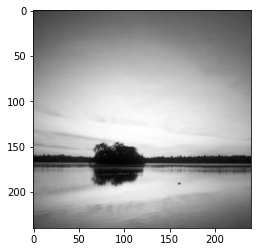

In [11]:
# Verify image
plt.imshow(cv2.resize(train_data[1], img_new_size), cmap='gray')
print(train_data[0].dtype)

In [12]:
n_train = len(train_label)
n_test = len(test_label)

# feature extraction
def extract_feat(raw_data):
    print(len(raw_data))
    feat_dim = 1000
    feat = np.zeros((len(raw_data), feat_dim), dtype=np.float32)
    for i in np.arange(feat.shape[0]):
        feat[i] = np.reshape(raw_data[i], (raw_data[i].size))[:feat_dim] # dummy implemtation
    print("feat",len(feat))
    
    return feat

train_feat = extract_feat(train_data)
test_feat = extract_feat(test_data)

# model training: take feature and label, return model
def train(X, Y):
    return 0 # dummy implementation

# prediction: take feature and model, return label
def predict(model, x):
    return np.random.randint(16) # dummy implementation

# evaluation
predictions = [-1]*len(test_feat)
for i in np.arange(n_test):
    predictions[i] = predict(None, test_feat[i])

accuracy = sum(np.array(predictions) == test_label) / float(n_test)

print("The accuracy of my dummy model is {:.2f}%".format(accuracy*100))

2400
feat 2400
400
feat 400
The accuracy of my dummy model is 5.75%


## Problem 1: Tiny Image Representation + Nearest Neighbor Classifier
{25 points} You will start by implementing the tiny image representation and the nearest neighbor classifier. They are easy to understand, easy to implement, and run very quickly for our experimental setup.

The "tiny image" feature is one of the simplest possible image representations. One simply resizes each image to a small, fixed resolution. You are required to **resize the image to 16x16**. It works slightly better if the tiny image is made to have zero mean and unit length (normalization). This is not a particularly good representation, because it discards all of the high frequency image content and is not especially invariant to spatial or brightness shifts. We are using tiny images simply as a baseline.

The nearest neighbor classifier is equally simple to understand. When tasked with classifying a test feature into a particular category, one simply finds the "nearest" training example (L2 distance is a sufficient metric) and assigns the label of that nearest training example to the test example. The nearest neighbor classifier has many desirable features — it requires no training, it can learn arbitrarily complex decision boundaries, and it trivially supports multiclass problems. It is quite vulnerable to training noise, though, which can be alleviated by voting based on the K nearest neighbors (but you are not required to do so). Nearest neighbor classifiers also suffer as the feature dimensionality increases, because the classifier has no mechanism to learn which dimensions are irrelevant for the decision.

Report your classification accuracy on the test sets and time consumption.

**Hints**:
- Use [cv2.resize()](https://docs.opencv.org/2.4/modules/imgproc/doc/geometric_transformations.html#resize) to resize the images;
- Use [NearestNeighbors in Sklearn](http://scikit-learn.org/stable/modules/neighbors.html) as your nearest neighbor classifier.

In [13]:
# Write your codes here
def tiny_img_conv(img, dimen):
  #Resize: Square 16x16
  dim = (dimen, dimen)
  img = cv2.resize(img, dim)
  #Normalize:
  img = (img - np.mean(img))/(np.std(img))
  img = img.flatten()
  return img
def create_tiny_matrix(img_list, dimen):
  output = []
  for img in img_list:
    output.append(tiny_img_conv(img, dimen))
  output = np.asarray(output)
  return output
def train_and_test(train_data, test_data, test_label):
  classifier = NearestNeighbors(n_neighbors=1) #increase p dramatically reduces performance output, distances are relatively the same, chebsheyev is worse
  neighbors = classifier.fit(train_data)

  #predict:
  dist, nearest_neigh = neighbors.kneighbors(test_data)
  pred = list(map(lambda x: train_label[x][0], nearest_neigh))
  return pred, test_label

start = time.time()
tiny_train_data = create_tiny_matrix(train_data, 16)
tiny_test_data = create_tiny_matrix(test_data, 16)


test_label = np.asarray(test_label).flatten()
pred1, label1 = train_and_test(tiny_train_data, tiny_test_data, test_label)
end = time.time()
print("Accuracy: ", accuracy_score(test_label, pred1)*100, "%")
print("Time Taken: ", end - start, "seconds")

Accuracy:  23.0 %
Time Taken:  0.2063438892364502 seconds


## Problem 2: Bag of SIFT Representation + Nearest Neighbor Classifer
{35 points}
After you have implemented a baseline scene recognition pipeline it is time to
move on to a more sophisticated image representation — bags of quantized SIFT
features. Before we can represent our training and testing images as bag of
feature histograms, we first need to establish a vocabulary of visual words. We
will form this vocabulary by sampling many local features from our training set
(10's or 100's of thousands) and then cluster them with k-means. The number of
k-means clusters is the size of our vocabulary and the size of our features. For
example, you might start by clustering many SIFT descriptors into k=50 clusters.
This partitions the continuous, 128 dimensional SIFT feature space into 50
regions. For any new SIFT feature we observe, we can figure out which region it
belongs to as long as we save the centroids of our original clusters. Those
centroids are our visual word vocabulary. Because it can be slow to sample and
cluster many local features, the starter code saves the cluster centroids and
avoids recomputing them on future runs.

Now we are ready to represent our training and testing images as histograms of
visual words. For each image we will densely sample many SIFT descriptors.
Instead of storing hundreds of SIFT descriptors, we simply count how many SIFT
descriptors fall into each cluster in our visual word vocabulary. This is done
by finding the nearest neighbor k-means centroid for every SIFT feature. Thus,
if we have a vocabulary of 50 visual words, and we detect 220 distinct SIFT
features in an image, our bag of SIFT representation will be a histogram of 50
dimensions where each bin counts how many times a SIFT descriptor was assigned
to that cluster. The total of all the bin-counts is 220. The histogram should be
normalized so that image size does not dramatically change the bag of features
magnitude.

After you obtain the Bag of SIFT feature representation of the images, you have to
train a KNN classifier in the Bag of SIFT feature space and report your test set accuracy and time consumption. 

**Note**: 
- Instead of using SIFT to detect invariant keypoints which is time-consuming,
  you are recommended to densely sample keypoints in a grid with certain step
  size (sampling density) and scale.
- There are many design decisions and free parameters for the bag of SIFT
  representation (number of clusters, sampling density, sampling scales, SIFT
  parameters, etc.) so accuracy might vary from 50% to 60%.
- Indicate clearly the parameters you use along with the prediction accuracy
  on test set and time consumption.

**Hints**:
- Use [KMeans in Sklearn](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)
  to do clustering and find the nearest cluster centroid for each SIFT feature;
- Use `cv2.xfeatures2d.SIFT_create()` to create a SIFT object;
- Use `sift.compute()` to compute SIFT descriptors given densely sampled keypoints
  ([cv2.Keypoint](https://docs.opencv.org/3.0-beta/modules/core/doc/basic_structures.html?highlight=keypoint#keypoint)).
- Be mindful of RAM usage. Try to make the code more memory efficient, otherwise it could easily exceed RAM limits in Colab, at which point your session will crash.
- If your RAM is going to run out of space, use [gc.collect()](https://docs.python.org/3/library/gc.html) for the garbage collector to collect unused objects in  memory to free some space.
- Store data or features as NumPy arrays instead of lists. Computation on NumPy arrays is much more efficient than lists.

In [14]:
import os
import sys
# Write your codes here
#size: 180 x 180 square sample, step = 6
height = 240
width = 240
step_size = 20
scale = 6

kp_arr = []
for r in range(0, height, step_size):
  for c in range(0, width, step_size):
    kp_arr.append(cv2.KeyPoint(r,c,step_size))
#print("kp_arr: ", kp_arr)
print("Sample Dimension: ", height, "x", width)
print("Step Size:", step_size, " Scale:", scale)
print("Total Keypoints: ", len(kp_arr))
gc.collect()
#obtain descriptors for each image in train_data:
start_desc = time.time()
sift = cv2.xfeatures2d.SIFT_create()
des_arr = []

train_props = [] #saving results
print("Number of Training Samples: ", len(train_data))

#saving results into a text file to avoid recomputation on future runs, saving approximate time as well
#desc_file = open("descriptor_extract.txt", "w+")
#print(desc_file.readline())
#sys.exit()
for img in train_data:
  key, desc = sift.compute(img, kp_arr)
  train_props.append((key, desc))
  des_arr.__iadd__(desc)
#write des_arr into text file
des_arr = np.asarray(des_arr, dtype = np.float32)
end_desc = time.time()
print("Number of Descriptors: ", len(des_arr))
print("Time Taken: ", end_desc - start_desc, "s")

Sample Dimension:  240 x 240
Step Size: 20  Scale: 6
Total Keypoints:  144
Number of Training Samples:  2400
Number of Descriptors:  345600
Time Taken:  170.6197681427002 s


In [15]:
#KMEANS:
kmeans_start = time.time()
clusters=60
kmclf = KMeans(n_clusters=clusters, random_state=0)
kmeans = kmclf.fit(des_arr)
kmeans_end = time.time()
print("K-Means Clustering with , ", clusters, " Clusters Took: ", kmeans_end - kmeans_start, "s")

K-Means Clustering with ,  60  Clusters Took:  623.5995206832886 s


In [16]:
#Calculating Histograms:
histograms_start = time.time()

train_hists = []
for img in train_props:
  key, des = img#sift.compute(img, kp_arr) -> use saved train_props to save time
  kp_num = np.size(key)
  hist = np.zeros(clusters)
  for j in des: #+1 in hist at k_mean index
    index = kmeans.predict(des) #find centroid
    hist[index] += 1
  hist/=kp_num #normalize
  train_hists.append(hist)
histograms_end = time.time()
print("Creating Histograms for ", len(train_data), " took: ", histograms_end-histograms_start, "seconds")


Creating Histograms for  2400  took:  125.5560839176178 seconds


In [22]:
#KNeighBor classifier training with bag of histograms
KNeigh_start_time = time.time()
num_neigh = 20
neigh = KNeighborsClassifier(n_neighbors=num_neigh, weights='distance')
neigh.fit(np.array(train_hists), train_label)

test_histograms = [] #change this
for image in test_data:
  kp, des = sift.compute(image, kp_arr)
  histogram = np.zeros(clusters)
  number_keypoints = np.size(kp)
  for d in des:
    index = kmeans.predict(des)
    histogram[index] += 1
  histogram/=number_keypoints
  test_histograms.append(histogram)
KNeigh_end_time = time.time()
print("Classifier Prediction Took: ", KNeigh_end_time - KNeigh_start_time, "seconds")

#For Extra Credit : 
test2_histograms = []
for image in test2_data:
  kp, des = sift.compute(image, kp_arr)
  histogram = np.zeros(clusters)
  number_keypoints = np.size(kp)
  for d in des:
    index = kmeans.predict(des)
    histogram[index] += 1
  histogram/=number_keypoints
  test2_histograms.append(histogram)

Classifier Prediction Took:  64.13721919059753 seconds


In [18]:
pred2 = neigh.predict(test_histograms)
acc = accuracy_score(test_label, pred2)
print("Accuracy is: ", acc*100, " %")

Accuracy is:  43.5  %


## Problem 3.a: Bag of SIFT Representation + one-vs-all SVMs
{15 points}
The last task is to train one-vs-all linear SVMS to operate in the bag of SIFT
feature space. Linear classifiers are one of the simplest possible learning
models. The feature space is partitioned by a learned hyperplane and test cases
are categorized based on which side of that hyperplane they fall on. Despite
this model being far less expressive than the nearest neighbor classifier, it
will often perform better.

You do not have to implement the support vector machine. However, linear
classifiers are inherently binary and we have a 16-way classification problem
(the library has handled it for you). To decide which of 16 categories a test
case belongs to, you will train 16 binary, one-vs-all SVMs. One-vs-all means
that each classifier will be trained to recognize 'forest' vs 'non-forest',
'kitchen' vs 'non-kitchen', etc. All 16 classifiers will be evaluated on each
test case and the classifier which is most confidently positive "wins". E.g. if
the 'kitchen' classifier returns a score of -0.2 (where 0 is on the decision
boundary), and the 'forest' classifier returns a score of -0.3, and all of the
other classifiers are even more negative, the test case would be classified as a
kitchen even though none of the classifiers put the test case on the positive
side of the decision boundary. When learning an SVM, you have a free parameter
$\lambda$ (lambda) which controls how strongly regularized the model is. Your
accuracy will be very sensitive to $\lambda$, so be sure to try many values.

Indicate clearly the parameters you use along with the prediction accuracy on
test set and time consumption.

**Bonus {10 points}**: For this question, you need to generate class prediction for the images in **test2** folder using your best model. The prediction file(**Surname_Givenname_SBUID_Pred.txt**) should follow the exact format as given in the **sample.txt** file.10 points will be given to students whose accuracy ranks top 3 in this homework.

**Hints**:
- Use SVM in
  [Sklearn](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.svm)
  (recommended) or
  [OpenCV](https://docs.opencv.org/3.0-alpha/modules/ml/doc/support_vector_machines.html)
  to do training and prediction.

In [19]:
# Write your codes here
import sklearn.multiclass as mc
def onevsall_model(train_hists, train_labels, test_hists, test_labels, lambda_val):
  clf = mc.OneVsRestClassifier(svm.SVC(C=lambda_val , kernel='linear', probability=True, random_state=42)) #ignored , random_state
  clf.fit(np.asarray(train_hists), train_labels)
  pred = clf.predict(np.asarray(test_hists))
  acc = accuracy_score(test_labels, pred)
  prev_max_pred = 0
  with open('max_pred.txt', 'r') as f:
    prev_max_pred_str = f.read()
    #print("prev_max_pred_str: ", prev_max_pred_str)
    prev_max_pred = float(prev_max_pred_str)
  
  filename = 'finalized_model.sav' #Computed Model Can be Loaded with Pickle
  if(acc > prev_max_pred):
    with open('max_pred.txt', 'w') as f:
       f.write('%f' % acc)
    pickle.dump(clf, open(filename, 'wb'))
  return pred

onevsall_start_time = time.time()
lbda = .19

pred3 = onevsall_model(train_hists, train_label, test_histograms, test_label, lbda)
onevsall_end_time = time.time()
#print("Pred: ", pred3)

acc = accuracy_score(test_label, pred3)
print("One vs All Classifier with lambda = ", lbda, "Took", onevsall_end_time - onevsall_start_time, "seconds")
print("Accuracy: ", acc*100, "%")
#pred3, label3 = # train_and_test(...


One vs All Classifier with lambda =  0.19 Took 5.388691425323486 seconds
Accuracy:  48.0 %


In [39]:
#Training on Test_2 for potential Extra Credit
prediction = onevsall_model(train_hists, train_label, test2_histograms, test_label, lbda)
filename = "Khan_Walid_112943185_Pred.txt"
f = open(filename, 'w')
for i in range(len(prediction)):
      img_pred = "image_"+str(i)+".jpg" + " " + str(prediction[i])
      f.write(img_pred)
      f.write("\n")
f.close()
#print("Predictions: ", prediction)


## Problem 3.b
{5 points} Repeat the evaluation above for different sizes of training sets and draw a plot to show how the size of the training set affects test performace. Do this for training set sizes of 800, 1200, 1600, 2000, 2200, and 2300 images. Randomly sample the images from the original training set and evaluate accuracy. Repeat this process 10 times for each training set size and report the average prediction accuracy. How does performance variability change with training set size? How does performance change? Give reason for your observations.

In [20]:
# Write your codes here
def shuffle_simult(arr1, arr2):
  arr1 = np.asarray(arr1)
  arr2 = np.asarray(arr2)
  p = np.random.permutation(len(arr1))
  return arr1[p], arr2[p]

trainset_sizes = [800, 1200, 1600, 2000, 2200, 2300]
for set_size in trainset_sizes:
  num_rounds = 10 
  performance_time_start = time.time()
  mean_acc = 0
  print("Accuracy Reports for size: ", set_size)
  for i in range(num_rounds):
    random_train_set, random_train_labels  = shuffle_simult(train_hists, train_label)
    random_train_set = random_train_set[0:set_size]
    random_train_labels = random_train_labels[0:set_size]
    pred = onevsall_model(random_train_set, random_train_labels, test_histograms, test_label, lbda)
    acc = accuracy_score(test_label, pred)
    print(acc*100, "% ,", end = ' ')
    mean_acc+=(acc/num_rounds)
  print("\nMean Accuracy: ", mean_acc*100, "%")
  performance_time_end = time.time()
  print("Total Time Taken is", performance_time_end - performance_time_start, "seconds\n")


Accuracy Reports for size:  800
45.5 % , 40.0 % , 43.75 % , 41.75 % , 44.0 % , 42.75 % , 44.25 % , 42.75 % , 46.0 % , 43.75 % , 
Mean Accuracy:  43.45 %
Total Time Taken is 6.9007487297058105 seconds

Accuracy Reports for size:  1200
42.75 % , 47.25 % , 45.75 % , 43.0 % , 44.5 % , 46.0 % , 41.25 % , 43.5 % , 45.75 % , 43.0 % , 
Mean Accuracy:  44.27499999999999 %
Total Time Taken is 14.173291683197021 seconds

Accuracy Reports for size:  1600
46.5 % , 46.0 % , 43.25 % , 44.5 % , 45.5 % , 46.5 % , 43.0 % , 46.75 % , 44.25 % , 48.5 % , 
Mean Accuracy:  45.474999999999994 %
Total Time Taken is 23.06485676765442 seconds

Accuracy Reports for size:  2000
45.5 % , 45.75 % , 44.75 % , 46.0 % , 47.25 % , 43.75 % , 45.0 % , 44.75 % , 47.25 % , 44.5 % , 
Mean Accuracy:  45.45 %
Total Time Taken is 34.07151651382446 seconds

Accuracy Reports for size:  2200
43.75 % , 48.0 % , 47.0 % , 46.5 % , 45.75 % , 47.5 % , 46.0 % , 46.25 % , 47.5 % , 45.5 % , 
Mean Accuracy:  46.37499999999999 %
Total Time 

Response to questions:

Performance:
The variability in performance decreases as we train on more test sets. This is due to the increasing bias and decreasing variance common when increasing training sets. Since the variance of the machine decreases, the difference (or variability) in results of the machine also decreases as we increase train set size.

The mean accuracy gradually increases with an increase in train set size, most likely due to forming higher biases/distinction for object classes in images. The increase in mean accuracy seems linear in proportion to the linear increase in train set size. The positive increase in mean accuracy decreased steadily as the rate of change in increasing train set size also decreased. 
i.e from 800 - 1200 a sizable increase in mean accuracy occured, whereas from 2200 - 2300, the difference was negligible. This could possibly be attributed to overfitting the training model, to where it reaches a peak mean accuracy and then gradually decreases, (a local maximum in performance).

## Performance Report
---
{20 points}
Please report the performance of the following combinations **in the given order**
in terms of the time consumed and classification accuracy. Describe your algorithm,
any decisions you made to write your algorithm in your particular way, and how
different choices you made affect it. Compute and draw a (normalized) [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix), and discuss
where the method performs best and worse for each of the combination.
Here is an [example](http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py) of how to compute confusion matrix.


1st: Tiny images representation and nearest neighbor classifier (accuracy of about 18-25%).<br>
2nd: Bag of SIFT representation and nearest neighbor - classifier (accuracy of about 40-50%). <br>
3rd: Bag of SIFT representation and linear SVM classifier (accuracy of about 50-70%). <br>

Performance Report:

1. 

  Tiny Image Representation and Nearest Neighbor Classifier:

  Accuracy:  23.0 %, Time Taken:  0.2070331573486328 seconds

  Used only numpy arrays (Faster Computation), 
  Tried different distance parameters in Nearest Neighbor Algorithm, including: Manhattan Distance and Chebsyev Distance
  Chebsyev Dramatically Reduced Performance in both Time and Accuracy
  Manhattan had similar performance to default Minowski Distance,
  thus I kept the parameter for distance as default minowski


2. 

  Bag Of SIFT + Nearest Neighbor:

  Accuracy: 43.5%, Time Taken: ~1,058 seconds

  Algorithm Notes:

  Clusters: 60

  Number of Neighbors: 20

  Scale: 6

  Step Size: 20

  Sample Size: 240 x 240

  Reasoning: 

  I initially tried over 60 clusters, which proved to be a mistake as the run time dramatically increased. I then low balled to 30 clusters, which took far less time, however the accuracy was much lower than the expected range. I incremneted by 5 clusters until I reached a suitable cluster amount, where both accuracy and run time were at peak.

  I tried different valyes for neighbors (usually more neighbors means more strict distinction of classes); however, upon increased the number of neighbors to ~50 the bias on the training set became too stark, causing a decrease in accuracy. This dip started at about 32 neighbors. However running more than 20 neighbors proved to cost too much in run time, leading me to stick to 20 neighbors.

  Statistics: 
  Sample Dimension:  240 x 240
  Step Size: 20  Scale: 6
  Total Keypoints:  144
  Number of Training Samples:  2400
  Number of Descriptors: 345600

  Algorithm Specific:

  I tried to reuse computed data wherever possible, in specific I saved the keypoint, descriptor tuples into an array so that I may reuse them for training histogram generation. This lowered runtime by 20 ~ 30 seconds.

  I tried different step sizes and when lessened the number of descriptors increase by a factor, and are clustered closer, this lead to a slight increase in accuracy, but had the adverse effect on runtime, for that reason I kept it at a modest 20.

3. 
  Bag of SIFT Representation + one-vs-all SVMs
  One vs All Classifier with lambda =  0.4 Took 6.060097694396973 seconds
  Accuracy:  45.5 %

  Reasoning:
  The performance is slightly low which is due to using a lower number of    clusters, the if the number of clusters is changed to 70+, the accuracy is between 50 - 60 % accurate. Other considerations such as sample size and descriptor density also affect this rate. However, for this project, I chose to keep it at 60 purely due to run time when computing image histograms.

  Algorithm Specific:
  After creating a multiclass one vs all model, I saved the model into an sav file, that updates if a new model is trained with a higher accuracy output. This was done so that I may test the current model without having to recompute histograms. Saving the model file also allows for compartmization.

  The main parameter that I attempted to optimize was the lambda. I tried values from [0,3] , the accuracy started to dip at .19, therefor I kept the lambda value at that peak. 

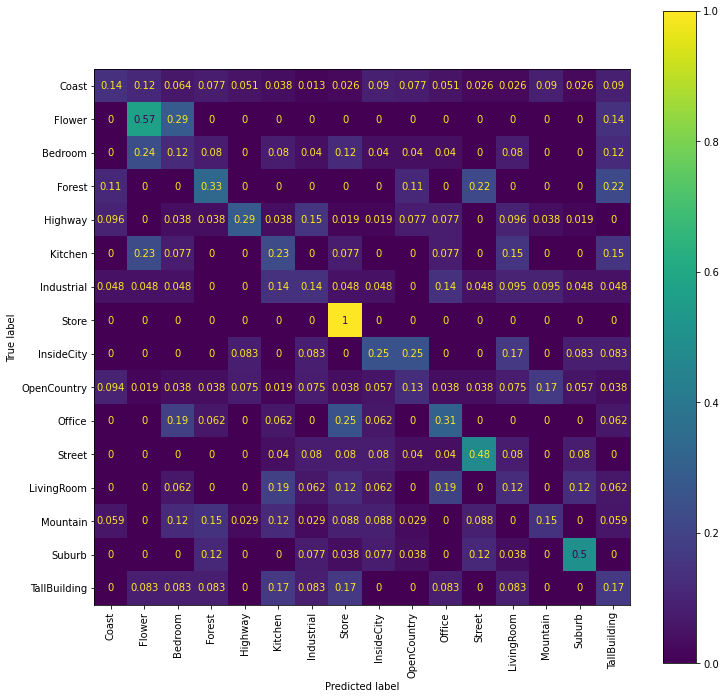

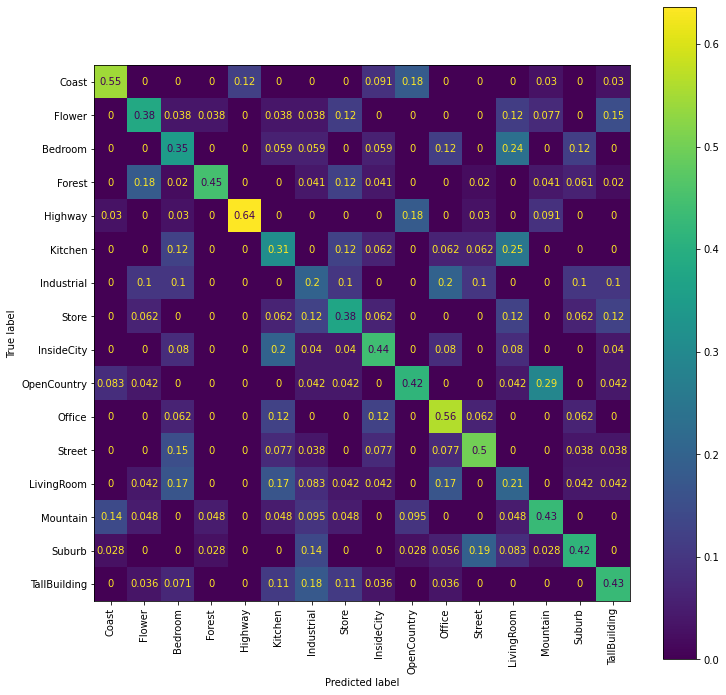

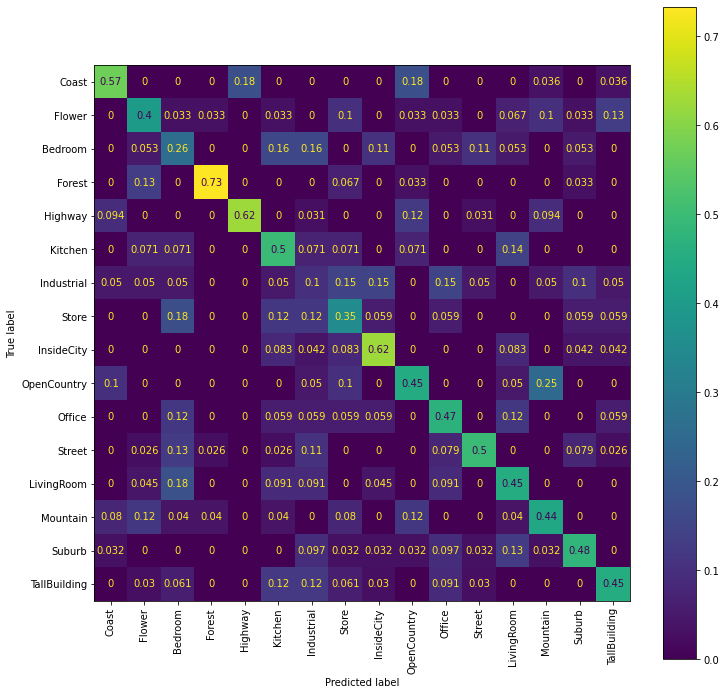

In [21]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
def plot_confusion_matrix(cm, classes, ax,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize == True:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] #Found from docs
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(ax=ax)
c_names = [name[13:] for name in glob.glob('./data/train/*')]
label2 = label3 = test_label
#First combination:
# Confusion matrix
cm1 = confusion_matrix(pred1, label1)
fig, ax = plt.subplots(figsize=(12,12))
plot_confusion_matrix(cm1, c_names, ax, normalize=True)
plt.xticks(rotation=90)
plt.show()

#Second combination:
# Confusion matrix
cm2 = confusion_matrix(pred2, label2)
fig, ax = plt.subplots(figsize=(12,12))
plot_confusion_matrix(cm2, c_names, ax, normalize=True)
plt.xticks(rotation=90)
plt.show()

#Third combination:
# Confusion matrix
cm3 = confusion_matrix(pred3, label3)
fig, ax = plt.subplots(figsize=(12,12))
plot_confusion_matrix(cm3, c_names, ax, normalize=True)
plt.xticks(rotation=90)
plt.show()

## Submission guidelines
---
Extract the downloaded .zip file to a folder of your preference. The input and output paths are predefined and **DO NOT** change them, (we assume that 'Surname_Givenname_SBUID_hw4' is your working directory, and all the paths are relative to this directory).  The image read and write functions are already written for you. All you need to do is to fill in the blanks as indicated to generate proper outputs. **DO NOT** zip and upload the dataset on blackboard due to size limit.

When submitting your .zip file through blackboard, please
-- name your .zip file as **Surname_Givenname_SBUID_hw*.zip**.

This zip file should include:
```
Surname_Givenname_SBUID_hw*
        |---Surname_Givenname_SBUID_hw*.ipynb
        |---Surname_Givenname_SBUID_hw*.pdf
        |---Surname_Givenname_SBUID_Pred*.txt
```

For instance, student Michael Jordan should submit a zip file named "Jordan_Michael_111134567_hw4.zip" for homework 4 in this structure:
```
Jordan_Michael_111134567_hw4
        |---Jordan_Michael_111134567_hw4.ipynb
        |---Jordan_Michael_111134567_hw4.pdf
        |---Jordan_Michael_111134567_Pred.txt
```

The **Surname_Givenname_SBUID_hw*.pdf** should include a **google shared link** and **Surname_Givenname_SBUID_Pred*.pdf** should be your test set prediction file in the specified format. To generate the **google shared link**, first create a folder named **Surname_Givenname_SBUID_hw*** in your Google Drive with your Stony Brook account. The structure of the files in the folder should be exactly the same as the one you downloaded. If you alter the folder structures, the grading of your homework will be significantly delayed and possibly penalized.

Then right click this folder, click ***Get shareable link***, in the People textfield, enter the TA's email: **sraval@cs.stonybrook.edu**. Make sure that TAs who have the link **can edit**, ***not just*** **can view**, and also **uncheck** the **Notify people** box.

Colab has a good feature of version control, you should take advantage of this to save your work properly. However, the timestamp of the submission made in blackboard is the only one that we consider for grading. To be more specific, we will only grade the version of your code right before the timestamp of the submission made in blackboard. 

You are encouraged to post and answer questions on Piazza. Based on the amount of email that we have received in past years, there might be dealys in replying to personal emails. Please ask questions on Piazza and send emails only for personal issues.

Be aware that your code will undergo plagiarism check both vertically and horizontally. Please do your own work.

**Late submission penalty:** <br>
There will be a 10% penalty per day for late submission. However, you will have 4 days throughout the whole semester to submit late without penalty. Note that the grace period is calculated by days instead of hours. If you submit the homework one minute after the deadline, one late day will be counted. Likewise, if you submit one minute after the deadline, the 10% penaly will be imposed if not using the grace period.

## Attention on HW submission
---
Based on the issues we observed during previous grading, we would like to ***stress*** the following.

* Submit the ***zip file*** containing (a notebook, pdf of sharable link, results) on Blackboard, ***not only*** the pdf with link.

* Link in the pdf should be directed to the ***folder*** on Google Drive, not the notebook alone.

* ***DO NOT*** change the structure of the notebook. If you need additional codes, just add new cells. ***DO NOT*** delete existing cells.

* Notebook should run without errors by by clicking ***'run all'*** . Verify this before submission. Because we need to run all your notebooks for grading. (Your folder structure, paths on Google Drive should be correct.)

* ***DO NOT*** remove the outputs visualized in the notebook. We check both the codes and the outputs.

* Make sure you submit the notebook in which you coded your answers.

* Read the questions ***carefully***, as they may contain sub parts or even hints.

* Share your notebook with ***EDIT ACCESS*** to : **sraval@cs.stonybrook.edu**. Uncheck the Notify people box.

If you don’t follow these instructions you will be penalized and the grading will be significantly delayed.

